# Laboratorio 02

In [32]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import cv2 as cv
from scipy.ndimage import convolve
from skimage.feature import hog
from skimage import io, color

In [14]:
image_name = "person.png"

In [15]:
image = cv.imread(f'images/{image_name}', cv.IMREAD_GRAYSCALE)
# Convert to numpy array
image = np.array(image) / 255.0

## Inciso 1

In [16]:
def resize_image(image, k = 1):
		# (128k, 64k) is the new size of the image
		new_size = (int(128 * k), int(64 * k))
		# Resize the image
		image = sk.transform.resize(image, new_size, anti_aliasing=True)
		return image

In [17]:
resized_image = resize_image(image, 1)

## Inciso 2

In [19]:
def prewitt_operator(grayscale_image):
    # Kernels Perwitt
    Gx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    Gy = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    
    # Compute the gradient in the x and y directions
    grad_x = convolve(grayscale_image, Gx)
    grad_y = convolve(grayscale_image, Gy)
    
    # Compute the gradient magnitude
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    # Compute the gradient direction (angle)
    angle = np.arctan2(-grad_y, grad_x) * (180 / np.pi)
    # Ensure the angle is within 0 to 180 degrees
    angle[angle < 0] += 180
    angle = angle % 180
    
    return magnitude, angle

In [20]:
magnitude, angle = prewitt_operator(resized_image)

In [21]:
def generate_magnitude_and_angle_for_image(image_name, k=1):
		image = cv.imread(f'images/{image_name}', cv.IMREAD_GRAYSCALE)
		# Convert to numpy array
		image = np.array(image) / 255.0
		resized_image = resize_image(image, k)
		magnitude, angle = prewitt_operator(resized_image)
		return magnitude, angle

In [22]:
k = 1
magnitude, angle = generate_magnitude_and_angle_for_image(image_name, k)

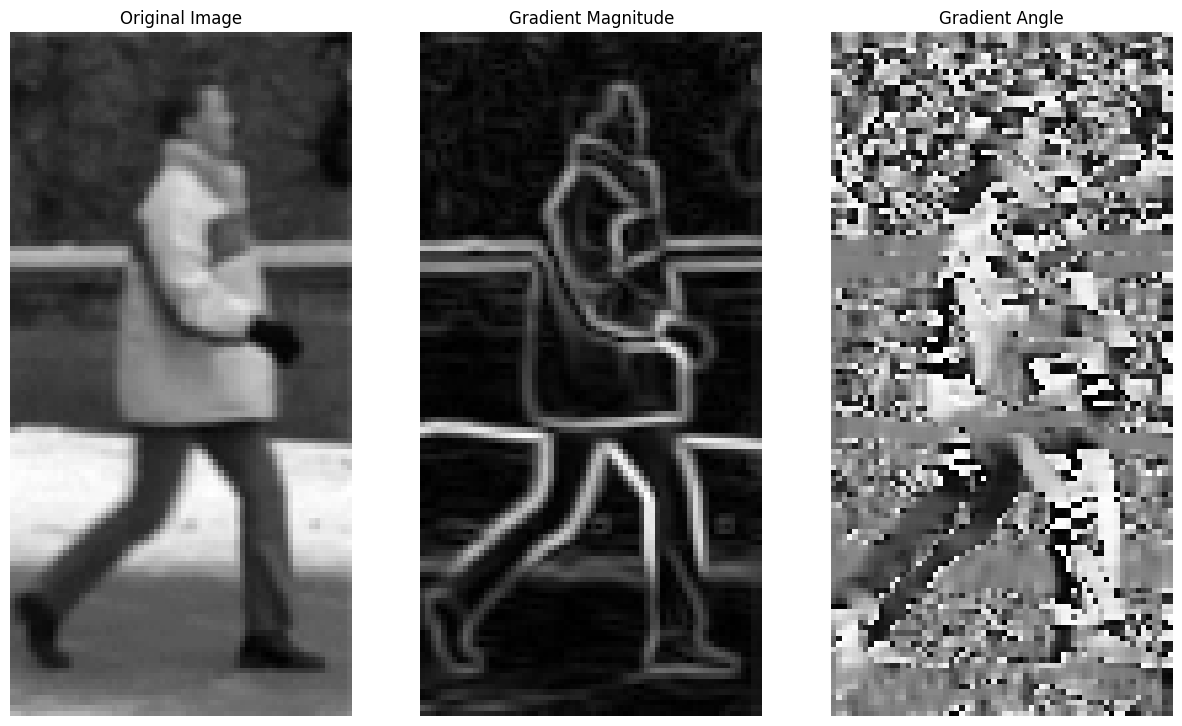

In [23]:
# Create a figure to display the results
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
ax = axes.ravel()
ax[0].imshow(resized_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(magnitude, cmap='gray')
ax[1].set_title('Gradient Magnitude')
ax[1].axis('off')
ax[2].imshow(angle, cmap='gray')
ax[2].set_title('Gradient Angle')
ax[2].axis('off')
plt.axis('off')
plt.show()

In [24]:
magnitude.shape

(128, 64)

In [25]:
def get_block(area, row_step, col_step, block_size): return area[row_step : row_step + block_size, col_step : col_step + block_size]

def gen_blocks_stacks(magnitude, angle, block_size):
    
    WIDTH, HEIGHT = magnitude.shape
    STRIDE = block_size // 2
    M = int((WIDTH / STRIDE) - 1)
    N = int((HEIGHT / STRIDE) - 1)

    blocks_magnitude = np.zeros((M, N, block_size, block_size))
    blocks_angle = np.zeros((M, N, block_size, block_size))


    for i in range(M):
        for j in range(N):
            row_step = i * STRIDE
            col_step = j * STRIDE

            blocks_magnitude[i, j] = get_block(magnitude, row_step, col_step, block_size)
            blocks_angle[i, j] = get_block(angle, row_step, col_step, block_size)

            
    return blocks_magnitude, blocks_angle

block_size = 15
blocks_magnitude, blocks_angle = gen_blocks_stacks(magnitude, angle, block_size)

In [26]:
blocks_magnitude.shape

(17, 8, 15, 15)

In [27]:
def build_histograms(m_bstack, a_bstack, n_bins):
    M, N, block_size, _ = m_bstack.shape
    histograms = np.zeros((M, N, n_bins))
    bin_centers = np.linspace(0, 180, n_bins, endpoint=False)

    for i in range(M):
        for j in range(N):
            m_block = m_bstack[i, j]
            a_block = a_bstack[i, j]
            histogram = np.zeros(n_bins)

            for k in range(block_size):
                for l in range(block_size):
                    angle = a_block[k, l]
                    magnitude = m_block[k, l]
                    
                    new_magnitude = None
                    angle_diff = np.abs(angle - bin_centers)
                    for idx, _ in enumerate(angle_diff):
                        if idx < len(angle_diff) - 1 and angle_diff[idx] == angle_diff[idx + 1]:
                            new_magnitude = magnitude / 2
                            histogram[idx] += new_magnitude
                            histogram[idx + 1] += new_magnitude
                            break
                    
                    if new_magnitude == None:
                        idx = np.argmin(angle_diff)
                        histogram[idx] += magnitude

            histogram = histogram / np.linalg.norm(histogram)
            histograms[i, j] = histogram            

    return histograms

n_bins = 9
histograms = build_histograms(blocks_magnitude, blocks_angle, n_bins)

In [28]:
histograms.shape

(17, 8, 9)

In [29]:
histograms

array([[[0.12566017, 0.30603941, 0.3315225 , ..., 0.41192574,
         0.2746121 , 0.20324133],
        [0.12993956, 0.26360074, 0.24897939, ..., 0.31899604,
         0.42874185, 0.29820302],
        [0.09218626, 0.26456104, 0.21200901, ..., 0.40737005,
         0.35294759, 0.35188349],
        ...,
        [0.10651015, 0.24591421, 0.13994553, ..., 0.2512052 ,
         0.32992544, 0.64719334],
        [0.05186609, 0.28216096, 0.26523394, ..., 0.40434505,
         0.36303313, 0.29033458],
        [0.12097439, 0.33301837, 0.50839857, ..., 0.16370104,
         0.36975892, 0.50795861]],

       [[0.1300743 , 0.38761146, 0.34416584, ..., 0.44083237,
         0.26772075, 0.39016729],
        [0.17577416, 0.40163936, 0.3452175 , ..., 0.35076013,
         0.40878585, 0.39794995],
        [0.18352903, 0.36067792, 0.3944252 , ..., 0.2745904 ,
         0.2740178 , 0.48225922],
        ...,
        [0.17277281, 0.4319733 , 0.1341002 , ..., 0.24588162,
         0.42661449, 0.66256401],
        [0.0

## Inciso 5

In [77]:
def draw_line(img, center, angle, length, intensity):
    """Dibuja líneas desde el centro en ambas direcciones según el ángulo."""
    for sign in [-1, 1]:  # Dibuja en ambas direcciones
        end_x = center[0] + sign * length * np.cos(angle)
        end_y = center[1] + sign * length * np.sin(angle)
        
        # Asegurarse de que los índices estén dentro de los límites
        x, y = np.linspace(center[0], end_x, num=100), np.linspace(center[1], end_y, num=100)
        ix, iy = np.clip(x, 0, img.shape[1]-1).astype(int), np.clip(y, 0, img.shape[0]-1).astype(int)
        img[iy, ix] = intensity

def draw_histogram_block(histogram, max_global_value, block_size=16, max_length=7):
    """Dibuja el histograma en un bloque con líneas que representan los valores, normalizado globalmente."""
    img = np.zeros((block_size, block_size))
    center = (block_size // 2, block_size // 2)
    
    for i, value in enumerate(histogram):
        # Calcula el ángulo y la intensidad de la línea, usando la normalización global
        angle = (np.pi * i / (len(histogram) - 1)) + (np.pi / 2)  # Distribuye los ángulos sobre 180 grados
        intensity = value / max_global_value  # Normaliza la intensidad de la línea globalmente
        length = max_length * intensity  # Ajusta la longitud de la línea según la intensidad
        
        draw_line(img, center, angle, length, intensity)
    
    return img

def create_composite_image(histograms, block_size=16, max_global_value=None):
    # Si max_global_value no se proporciona, calcularlo a partir de todos los histogramas
    if max_global_value is None:
        max_global_value = histograms.max()

    # Dimensiones de la imagen compuesta
    num_blocks_y, num_blocks_x, _ = histograms.shape
    comp_height = num_blocks_y * block_size
    comp_width = num_blocks_x * block_size
    
    # Crear imagen compuesta inicializada en negro
    composite_image = np.zeros((comp_height, comp_width))
    
    # Iterar sobre cada bloque para dibujarlo en la posición correcta
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Generar la imagen del bloque actual
            block_image = draw_histogram_block(histograms[i, j], max_global_value, block_size)
            # Calcular la posición superior izquierda donde colocar el bloque
            top_left_y = i * block_size
            top_left_x = j * block_size
            # Colocar el bloque en la imagen compuesta
            composite_image[top_left_y:top_left_y + block_size, top_left_x:top_left_x + block_size] = block_image
    
    return composite_image

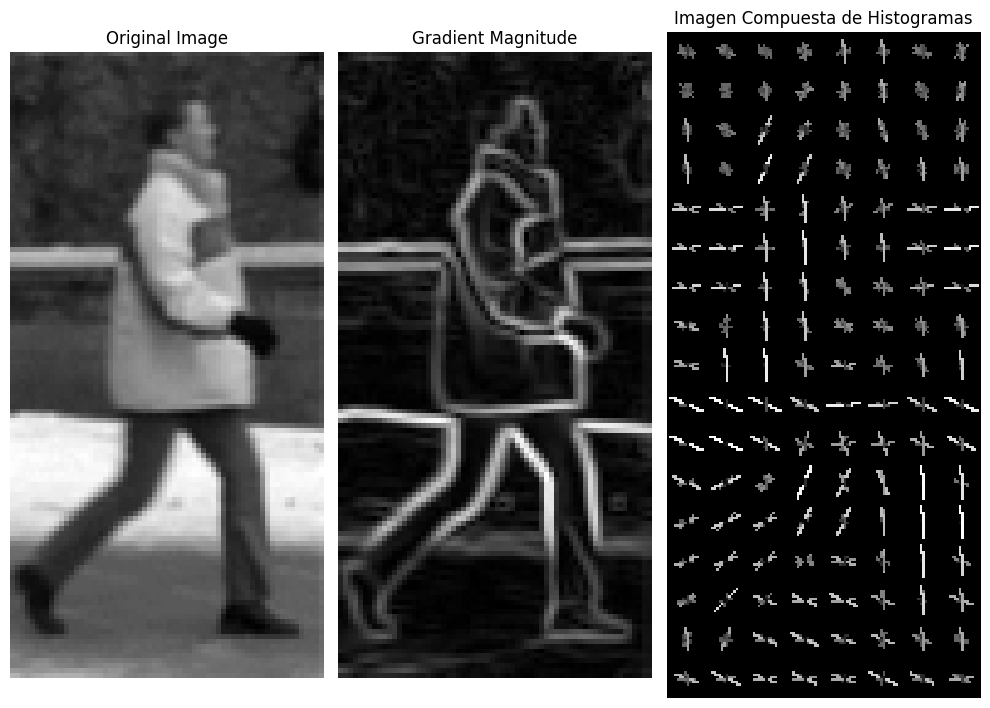

In [78]:
composite_image = create_composite_image(histograms)
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

ax[0].imshow(resized_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(magnitude, cmap='gray')
ax[1].set_title('Gradient Magnitude')
ax[1].axis('off')


ax[2].imshow(composite_image, cmap='gray', interpolation='nearest')
ax[2].set_title("Imagen Compuesta de Histogramas")
ax[2].axis('off')

plt.tight_layout()
plt.show()


## Inciso 6

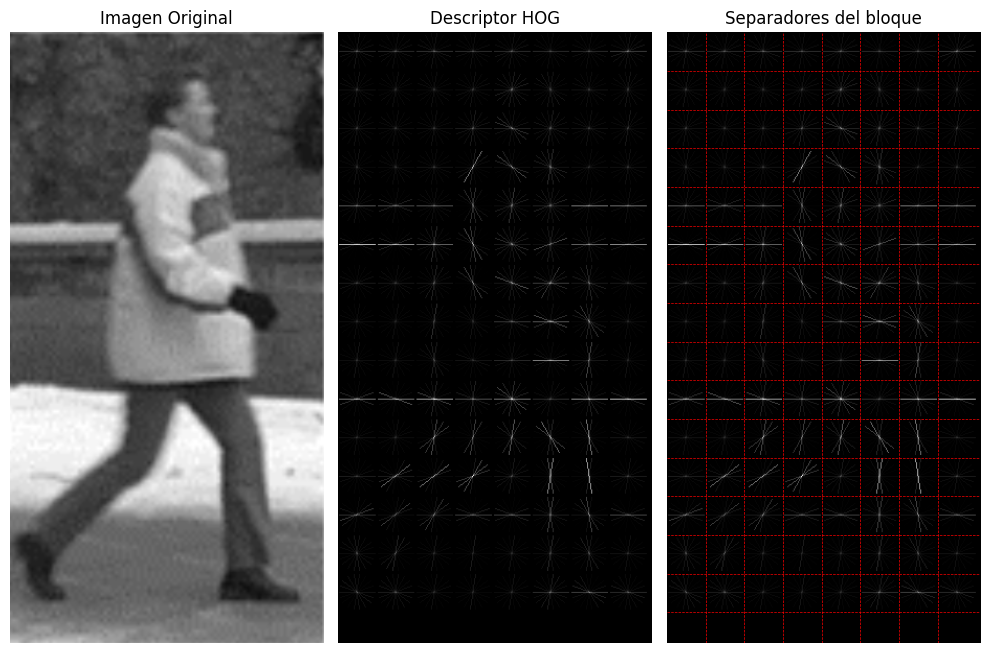

In [64]:
# Procesado de imagen
image_rgb = io.imread('images/person.png')

if image_rgb.shape[2] == 4:
    image_rgb = image_rgb[:, :, :3]

image_gray = color.rgb2gray(image_rgb)

alto, ancho = 585, 300
tamaño_bloque_horizontal = ancho // 8
bloques_verticales = int(np.ceil(alto / tamaño_bloque_horizontal))
tamaño_bloque = (tamaño_bloque_horizontal, tamaño_bloque_horizontal)

# Calcular el descriptor HOG con bloques cuadrados
fd, hogI = hog(image_gray, orientations=9, pixels_per_cell=tamaño_bloque, cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(image_rgb)
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(hogI, cmap='gray')
axes[1].set_title('Descriptor HOG')
axes[1].axis('off')

axes[2].imshow(hogI, cmap='gray')
axes[2].set_title('Separadores del bloque')
axes[2].axis('off')

for i in range(1, 8):
    axes[2].axvline(x=i*tamaño_bloque_horizontal, color='r', linestyle='--', linewidth=0.5)
for i in range(1, bloques_verticales):
    axes[2].axhline(y=i*tamaño_bloque_horizontal, color='r', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

Después de comparar las imágenes generadas utilizando dos enfoques diferentes, uno utilizando funciones de bibliotecas como skimage y otro implementado desde cero, se observan diferencias significativas en los resultados. 

El enfoque utilizando funciones de biblioteca proporciona una imagen con una definición clara de las formas y características de la imagen original, gracias a los algoritmos y métodos optimizados implementados en las bibliotecas. Las líneas que representan los gradientes y los bloques del histograma son claras y precisas, lo que permite una comprensión visual efectiva de la distribución de los gradientes en la imagen.

Por otro lado, el enfoque desde cero ofrece un resultado que, si bien proporciona información sobre los gradientes presentes en la imagen, carece de la definición y claridad de la imagen generada utilizando las funciones de la biblioteca. Las líneas que representan los gradientes y los bloques del histograma son más gruesas y menos precisas, lo que puede dificultar la interpretación visual de la información contenida en la imagen.

En conclusión, aunque ambos enfoques son válidos y ofrecen información sobre los gradientes presentes en la imagen, el enfoque utilizando funciones de biblioteca proporciona resultados más claros y precisos, lo que lo hace más adecuado para aplicaciones donde se requiere una representación visual precisa de los gradientes de la imagen. Por otro lado, el enfoque desde cero puede ser útil en situaciones donde se necesite un control detallado sobre el proceso de cálculo de los gradientes y los bloques del histograma, aunque esto pueda implicar una pérdida en la calidad visual de la imagen resultante.

## Inciso 7

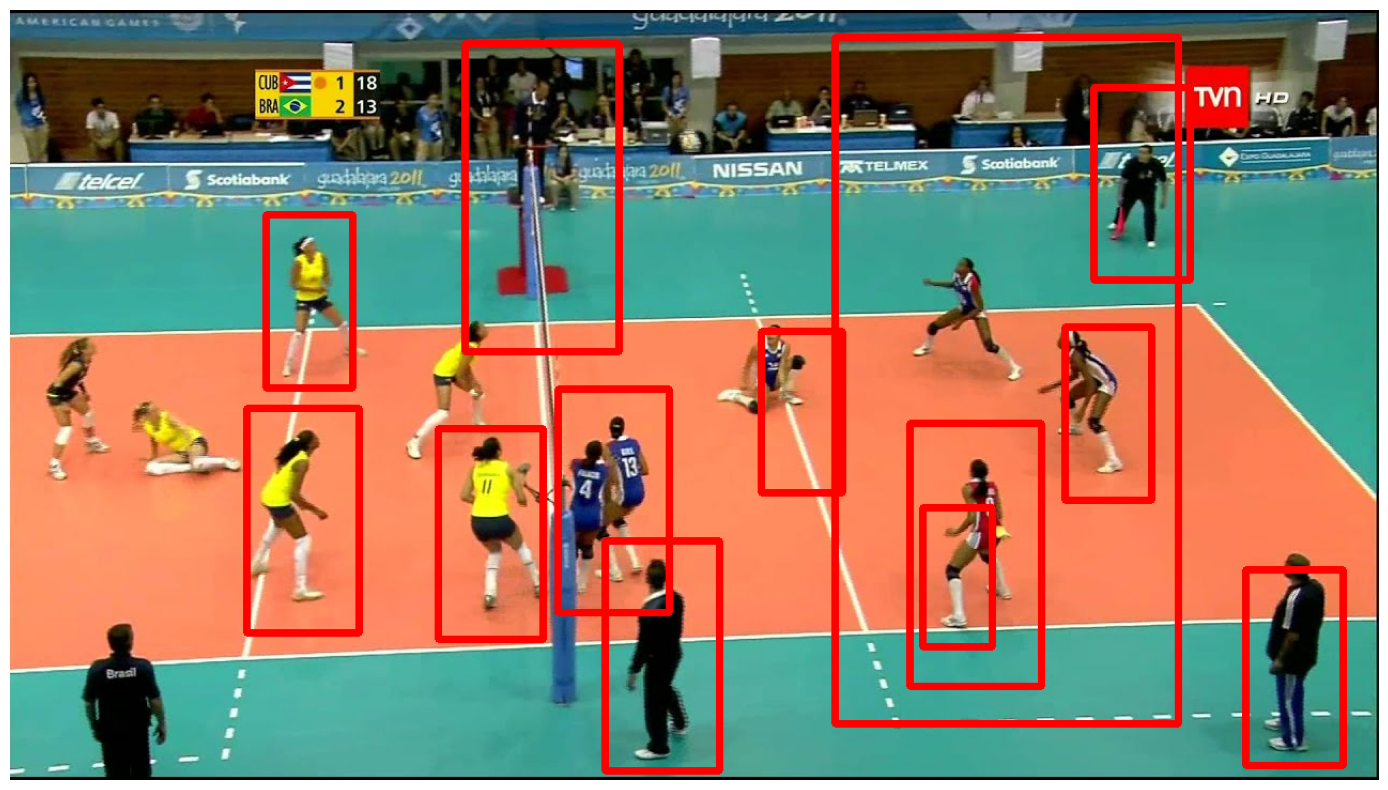

In [84]:
# Cargar la imagen
image_path = 'images/volei.jpeg'
image = cv.imread(image_path)

# Crear el detector HOG pre-entrenado para la detección de personas
hog_detector = cv.HOGDescriptor()
hog_detector.setSVMDetector(cv.HOGDescriptor_getDefaultPeopleDetector())

# Detectar personas en la imagen
locations, confidence = hog_detector.detectMultiScale(image)

# Dibujar los rectángulos alrededor de las personas detectadas
for (x, y, w, h) in locations:
    cv.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 5)

image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(20, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()